---
---
*<h1 align='center'> Violence Detection in Videos </h1>*

***<h2 align='center'> Progress - 3 </h2>***

---
---
Name: Logesh.V <br>
Email: vlogesh2001@gmail.com <br>
DATASETS: 
- Real Life Violence Situations Dataset: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset </br>
size: 2GB, 1000-Violence / 1000-NonViolence
- Hockey Fight Detection Dataset: https://academictorrents.com/details/38d9ed996a5a75a039b84cf8a137be794e7cee89 </br>
size: 212MB, 500-Violence / 500-NonViolence
- Movies Fight Detection Dataset: https://academictorrents.com/details/70e0794e2292fc051a13f05ea6f5b6c16f3d3635 </br>
size: 734MB, 100-Violence / 100-NonViolence
- Violent-Flows - Crowd Violence \ Non-violence Database: http://www.cslab.openu.ac.il/download/violentflow/ </br>
size: 240MB, 146-Violence / 125-NonViolence (links to yt videos are no longer valid in csv files)

### **Importing required packages**

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
#matplotlib.rcParams.update({'text.color' : "blue"})
from IPython.display import HTML

import os
from tqdm import tqdm # to get progress bars while running
import cv2
from sklearn.utils import shuffle

from tensorflow import keras
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

### **Load Premilinary Funtions**

In [2]:
# all pre-processing funtions Returns Video converted to list of frames of shape (height, width, channels)

def ReadVideo(dim,filename,framerate):
    cap = cv2.VideoCapture(filename)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_multiplier = total_frames/framerate
    
    # Read Video Frames according to req-frames:file-frames ratio
    frame_counter = 0
    while(cap.isOpened()):
        status,frame = cap.read()
        if(status):
            if(frame_counter%frame_multiplier <= 1):
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # so we are converting to RGB format
                
                # cropping out black border areas
                gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                _,thresh = cv2.threshold(gray,5,255,cv2.THRESH_BINARY) # threshold => 255 > pixel_value > 5 
                contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
                
                max_dim = 100 # finding the max bounds, keep threshold 100 min req pixels
                for k in contours:
                    _,_,tw,th = cv2.boundingRect(k)
                    if tw*th > max_dim :
                        max_dim = tw*th
                        x,y,w,h = cv2.boundingRect(k)
                if max_dim == 100:
                    continue # means complete black screen, skip this frame
                crop = image[y:y+h,x:x+w]
                # resizing
                img = cv2.resize(crop, (dim[0], dim[1])) 
                # normalization added in model
                
                frames.append(img)
            frame_counter = frame_counter + 1;
        else:
            cap.release() # closing video file if not more fromes present
    # returns list of frames (atmost frame-rate)
    return frames


def ExtractMotion(frames): # need to return a copy, not modify in frame itself
    blobs =[]
    for i in range(1,len(frames)):
        blobs.append(np.absolute(frames[i] - frames[i-1])) # abs diff bet 2 consecutive frames
    return blobs


def ResizeFrames(frames, outframes):
    frame_counter = len(frames)
    nt = 1
    while(frame_counter!=outframes):
        middle = frame_counter//2
        if(outframes-frame_counter < 0):
            # removing frames
            if((frame_counter-outframes)%2==0):
                if(frame_counter-1-2*nt < 0):
                    nt = nt//2
                frames.pop(frame_counter-1-2*nt)
                frames.pop(2*nt)
            else:
                frames.pop(middle)
        else:
            # add padding of slow-motion effect like
            # repeating frames in middle
            if((frame_counter-outframes)%2==0):
                if(middle+2*nt > frame_counter-1):
                    nt = nt//2
                frames.insert(middle-2*nt,frames[middle-2*nt])
                frames.insert(middle+2*nt+1,frames[middle+2*nt+1])
            else:
                frames.insert(middle,frames[middle])
        nt = nt+1
        frame_counter = len(frames)
    return frames

In [3]:
# User-defined load data function to read our data folders and label each of the videos with 
# names of class-folder in sequential order
def Load_Data_classwise(root_dir, *class_folders, need_motions=True):
    '''To import the dataset from the directories and preprocess them'''
        
    # final outputs:
    videos=[]
    motions=[]
    labels=[]
    
    # iterate through folders in each dataset
    for folder in os.listdir(root_dir):
        if(folder in class_folders):
            
            label = class_folders.index(folder)
            
            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(root_dir, folder))):
                
                # get pathname of each image
                vid_path = os.path.join(os.path.join(root_dir, folder), file)
               
                # Open, rescale, pre-process(motion features), re
                try:
                    video = ReadVideo(frame_size,vid_path, max_frame_rate)
                except:
                    video = ReadVideo(frame_size,vid_path, output_frames+1)
                if (need_motions == True):
                    motion = ExtractMotion(video) # motion blobs --> abs diff bet 2 consecutive frames
                    motion = ResizeFrames(motion, output_frames)
                
                video = ResizeFrames(video, output_frames)
                # Normalization is done in Model to avoid memory wasted 
                # by numpy as it turns data to float from int8
                    
                # Append the image and its corresponding label to the output
                videos.append(video)
                if (need_motions == True):
                    motions.append(motion)
                labels.append(label)
                
            print(root_dir+"... Loading-Class", label, "-->", folder, "over.")
                
    # Converting the data type of the list
    if (need_motions == True):
        return np.array(videos), np.array(motions), np.array(labels, dtype = 'int8')
    else:
        return np.array(videos), np.array(labels, dtype = 'int8')

In [4]:
# User-defined load data function to read our data folders and label each of the videos with 
# names of file_prefixes in sequential order
def Load_Data_prefixwise(folder_dirs, *file_prefixes, need_motions=True):
    '''To import the dataset from the directories and preprocess them'''
    
    # final outputs:
    videos=[]
    motions=[]
    labels=[]
    
    # iterate through folders
    for folder_dir in folder_dirs:
        
        # iterate through each image in folder
        for file in tqdm(os.listdir(folder_dir)):  
            
            for i in range(len(file_prefixes)):
                if (file.startswith(file_prefixes[i])):
                    
                    # get pathname of each image
                    vid_path = os.path.join(folder_dir, file) 
                    
                    # Open, rescale, pre-process(motion features), re
                    try:
                        video = ReadVideo(frame_size,vid_path, max_frame_rate)
                    except:
                        video = ReadVideo(frame_size,vid_path, output_frames+1)
                    if (need_motions == True):
                        motion = ExtractMotion(video) # motion blobs --> abs diff bet 2 consecutive frames
                        motion = ResizeFrames(motion, output_frames)
                    
                    video = ResizeFrames(video, output_frames)
                    # Normalization is done in Model to avoid memory wasted 
                    # by numpy as it turns data to float from int8
                    
                    # Append the image and its corresponding label to the output
                    videos.append(video)
                    if (need_motions == True):
                        motions.append(motion)
                    labels.append(i)
                
        print(folder_dir+"... Loading-Class with Prefixes", np.arange(len(file_prefixes)), "-->", file_prefixes, "over.")
                
    # Converting the data type of the list
    if (need_motions == True):
        return np.array(videos), np.array(motions), np.array(labels, dtype = 'int8')
    else:
        return np.array(videos), np.array(labels, dtype = 'int8')

In [5]:
def Combine_All(*VideosLabels):
    combine = []
    for x in range(len(VideosLabels[0])):
        combine.append(np.concatenate(tuple(i[x] for i in VideosLabels),axis=0))
    return tuple(combine)

### **Data Loading and Pre-Processing**

The proposed AlexNet CNN architecture is presented in Figure 2. In the proposed research work, image input layer is defined as a pre-processing layer where the input frames are down-sampled to 227×227 in terms of spatial resolution to reduce the computational cost of our deep learning.
framework.

In [6]:
class_names = ["Violence","NonViolence"]
frame_size = (112,112,3) # 112x112 for C3D
#max_frame_rate = 32 # max no.of frames taken while reading in one video 
output_frames = 16 # assumption that 16 consecutive frames are enough for this data to fit into C3D

In [6]:
class_names = ["Violence","NonViolence"]
frame_size = (224,224,3) # 224x224 for I3D
#max_frame_rate = 50 # max no.of frames taken while reading in one video 
output_frames = 25 # assumption that 16 consecutive frames are enough for this data to fit into I3D

In [7]:
# Loading Data - Train-Test videos
# if running in kaggle use: Load(kaggle_dir+"folder_dir",**class_folders)
#kaggle_dir = '/kaggle/input/violence-detection-in-videos'
videos, labels = Combine_All(Load_Data_classwise('Data/Real Life Violence Dataset', 'Violence', 'NonViolence', need_motions=False),
                             Load_Data_prefixwise(['Data/HockeyFights'], 'fi', 'no', need_motions=False),
                             Load_Data_classwise('Data/Peliculas', 'fights', 'noFights', need_motions=False),
                             Load_Data_classwise('Data/ViolentFlows/movies/1', 'Violence', 'NonViolence', need_motions=False),
                             Load_Data_classwise('Data/ViolentFlows/movies/2', 'Violence', 'NonViolence', need_motions=False),
                             Load_Data_classwise('Data/ViolentFlows/movies/3', 'Violence', 'NonViolence', need_motions=False),
                             Load_Data_classwise('Data/ViolentFlows/movies/4', 'Violence', 'NonViolence', need_motions=False),
                             Load_Data_classwise('Data/ViolentFlows/movies/5', 'Violence', 'NonViolence', need_motions=False),
                             Load_Data_classwise('Data/ViolentFlows/21VideosForDetection', 'ForTal', need_motions=False))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.14it/s]


Data/Real Life Violence Dataset... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:02<00:00,  4.12it/s]


Data/Real Life Violence Dataset... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.48it/s]


Data/HockeyFights... Loading-Class with Prefixes [0 1] --> ('fi', 'no') over.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.85it/s]


Data/Peliculas... Loading-Class 0 --> fights over.


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.67it/s]


Data/Peliculas... Loading-Class 1 --> noFights over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 42.24it/s]


Data/ViolentFlows/movies/1... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 35.98it/s]


Data/ViolentFlows/movies/1... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 42.25it/s]


Data/ViolentFlows/movies/2... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 35.47it/s]


Data/ViolentFlows/movies/2... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 41.30it/s]


Data/ViolentFlows/movies/3... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.92it/s]


Data/ViolentFlows/movies/3... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.54it/s]


Data/ViolentFlows/movies/4... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 35.69it/s]


Data/ViolentFlows/movies/4... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 39.70it/s]


Data/ViolentFlows/movies/5... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.97it/s]


Data/ViolentFlows/movies/5... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 14.97it/s]


Data/ViolentFlows/21VideosForDetection... Loading-Class 0 --> ForTal over.


In [8]:
print(f'Shape of Videos Data : {videos.shape}')

Shape of Videos Data : (3468, 25, 224, 224, 3)


### **Data Visualization**

Data: Labels and their count :
 Counter({0: 1744, 1: 1724})


Text(0, 0.5, 'Count')

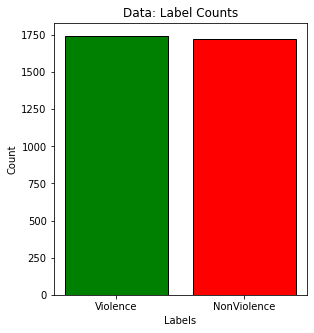

In [10]:
from collections import Counter
fig = plt.figure(figsize = (10,5))


label_count = Counter(labels)
print(f'Data: Labels and their count :\n {label_count}')
x = list(label_count.keys())
y = list(label_count.values())

plt.subplot(1,2,1)
plt.bar(x,y,color=['red','green'],  edgecolor='black')
plt.title('Data: Label Counts')
plt.xticks([0,1],class_names)
plt.xlabel('Labels')
plt.ylabel('Count')

In [11]:
def dis_rand_exp(videos, labels, x=3, y=6):
    
    fig = plt.figure(figsize = (20,12))
    fig.suptitle("Rand-Exps of dataset Videos --> Motion", fontsize=32)
    ax = []
    rand = []
    vp = []
    mp = []
    for i in range(0,x*y):
        # create a figure and axes
        ax.append(plt.subplot(x,y,i+1))
        # create objects that will change in the animation. These are
        # initially empty, and will be given new values for each frame
        # in the animation.
        rand.append(random.randint(0,len(labels)))
        vp.append(ax[i].imshow(videos[rand[-1]][0,:,:,:], cmap='gray'))
        ax[i].set_title(class_names[labels[rand[-1]]], fontsize=18)
    
    # set axes
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        a.axis('off')
    fig.subplots_adjust(left=0, bottom=0.1, right=0.1, top=0.2, wspace=0, hspace=0.5)
    fig.tight_layout()
    plt.close()
    
    # defining animation function
    def animate(i):
        for j in range(0,x*y):
            vp[j].set_data(videos[rand[j]][i,:,:,:])
        return vp,mp
    
    anim = animation.FuncAnimation(fig, animate, frames=output_frames, interval=60)
    return anim

In [ ]:
HTML(dis_rand_exp(videos, labels).to_jshtml())
# Output not shown, as it makes the file size too big, 
# its few frames of video in playback input representation after resp data preprocessing

---
*<h1 align='center'> Transfer Learning Models </h1>*

---

## C3D Model Feature Extracting + ML Classifiers
Description: C3D Model for Keras trained over Sports 1M</br>
Author: Alberto Montes</br>

Advisors: Xavier Giro and Amaia Salvador</br>

We provide an adaptation to Keras of the C3D model used with a fork of Caffe, which was trained over the Sports1M dataset.</br>

Details about the network architecture can be found in the following paper:</br>

Tran, Du, Lubomir Bourdev, Rob Fergus, Lorenzo Torresani, and Manohar Paluri. "Learning Spatiotemporal Features With 3D Convolutional Networks." In Proceedings of the IEEE International Conference on Computer Vision, pp. 4489-4497. 2015.</br>

Find our model and an example of how to use on this page on Github Gist.</br>

For more info: https://medium.com/@nair.binum/quick-overview-of-convolutional-3d-features-for-action-and-activity-recognition-c3d-138f96d58d8f </br>

Model link: https://gist.githubusercontent.com/albertomontesg/d8b21a179c1e6cca0480ebdf292c34d2/raw/1e2620258ce619e18d3219cf962a3f0a0ed17093/sports_1M.json </br>
 Weights link: https://drive.google.com/file/d/0BzmDUR5_3US0V1hjV3VvREJ3NGs/view?resourcekey=0-3EPDTvM5_Eaa1_tyH87LAg </br>
 
 Updated Keras version weights link: https://drive.google.com/file/d/1rlZ-xTkTMjgWKiQFUedRnHlDgQwx6yTm/view

### Features extraction
To extract features from a video you should:</br>

Divide a video into 16 frame chunks with 8 frame overlaps (dim=(16, 112, 112, 3)).</br>
Use output from the first fully connected layer **`fc6`** as a features from the single chunk. (implemented in sport1m_model.create_features_exctractor)
Average features extracted from all vectors to form a single vector (dim=4096).</br>
L2-normalize the vector.</br>

In [12]:
try: # .json gives error
    C3D_model = keras.models.model_from_json(open('sports_1M.json', 'r').read())
except: # recreating the same model architechture
    
    C3D_model = keras.models.Sequential([
        # 1st layer group
        keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv1', input_shape = (16, 112, 112, 3)),
        keras.layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1'),
        
        # 2nd layer group
        keras.layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2'),
        
        # 3rd layer group
        keras.layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a'),
        keras.layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'),
        
        # 4th layer group
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4a'),
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4b'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'),
        
        # 5th layer group
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5a'),
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5b'),
        keras.layers.ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5'),
        
        keras.layers.Flatten(),
        
        # FC layers group
        keras.layers.Dense(4096, activation='relu', name='fc6'),
        keras.layers.Dropout(.5),
        keras.layers.Dense(4096, activation='relu', name='fc7'),
        keras.layers.Dropout(.5),
        keras.layers.Dense(487, activation='softmax', name='fc8')
    ])


In [13]:
try:
    C3D_model.load_weights('sports1M_weights.h5')
except:
    C3D_model.load_weights('C3D_Sport1M_weights_keras_2.2.4.h5')
#C3D_model.compile(loss='mean_squared_error', optimizer='sgd')
C3D_model._name="C3D"
C3D_model.summary()

Model: "C3D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0       

In [14]:
print("\n\nPrinting layers of Model -",C3D_model.name,":")
for layer in C3D_model.layers:
    print(layer)

print("\nFeature extraction from the model:")
feature_layer = C3D_model.get_layer('fc6')
print(feature_layer)



Printing layers of Model - C3D :

Feature extraction from the model:


Instructions for updating:
Colocations handled automatically by placer.
C3D Model Architecture


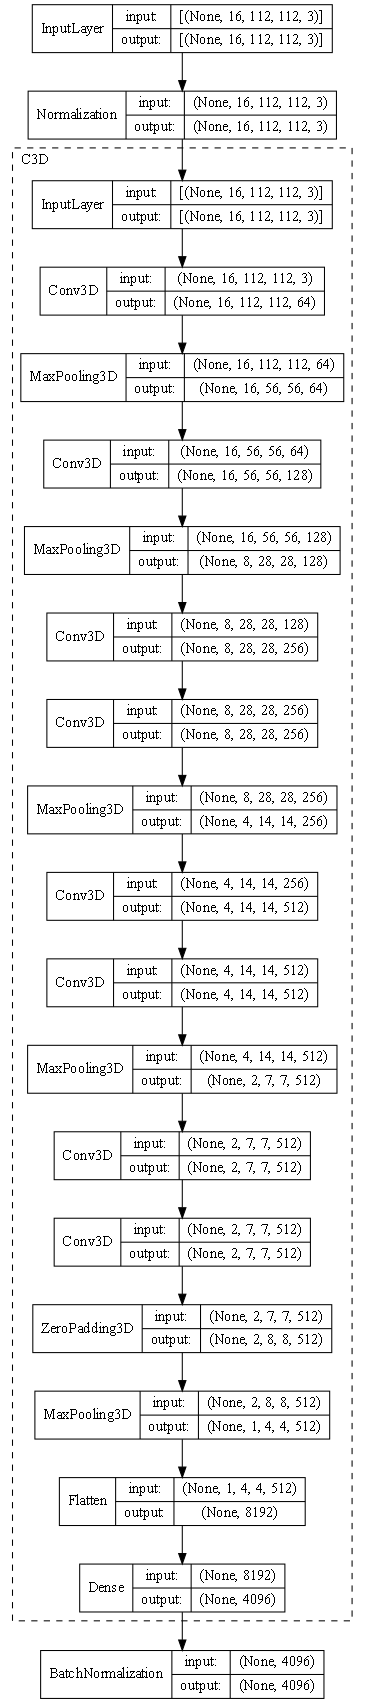

In [15]:
feature_model = keras.models.Sequential([
    ## preprocessing - Normalization
    keras.layers.Normalization(input_shape=(16, 112, 112, 3)),
    ## Feature Extractor
    keras.Model(inputs = C3D_model.inputs, outputs = feature_layer.output, name='C3D'),
    ## batch-normalizing for next classifier to train
    keras.layers.BatchNormalization()
])
feature_model._name="C3D_Feature_Extractor"

# Showing C3D Model Architecture
print("C3D Model Architecture")
keras.utils.plot_model(feature_model,'C3D.png',show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True, dpi=75)
# rankdir='TB' -> top to bottom
#feature_model.summary()

### **Extracting the deep features directly from Videos of our Dataset**
*(i.e., model **without** Fully-Connected-Layers[DNN] for Feature-Extracting))*

In [16]:
import time
tf.keras.backend.clear_session
start_time = time.time(); features = feature_model.predict(videos,batch_size=20); feat_time = time.time() - start_time;
print("Time time taken to extract features from complete Data -->:", feat_time, "(s)")

Time time taken to extract features from complete Data -->: 87.98200130462646 (s)


In [17]:
from sklearn.model_selection import train_test_split
train_features,test_features,train_labels,test_labels = train_test_split(features, labels, test_size=.2, shuffle=True)

In [18]:
print("Training data size:", train_features.shape)
print("Test data size:", test_features.shape)

Training data size: (2687, 4096)
Test data size: (781, 4096)


### *Searching for the best model*
These above features-data is given as inputs for ML-Classifiers and best out them is found

In [19]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

names = ["Linear SVM", "Poly SVM", "RBF SVM", "Sig SVM", "lbfgs Log-Reg", 
         "saga Log-Reg", "SGD", "Naive Bayes","Multinomial NB", "Gaussian Process", 
         "Decision Tree", "Random Forest", "KNN", "Neural Net", "AdaBoost", 
         "GradientBoost", "QDA", "LGBM", "XGB", "CatBoost"]

classifiers = [SVC(kernel='linear'), SVC(kernel='poly'), SVC(kernel='rbf'), SVC(kernel='sigmoid'), # comparison of all SVM kernels
               LogisticRegression(solver='lbfgs'), LogisticRegression(solver='saga'), SGDClassifier(), 
               GaussianNB(), MultinomialNB(), GaussianProcessClassifier(), 
               DecisionTreeClassifier(max_depth=10), RandomForestClassifier(max_depth=10), KNeighborsClassifier(), 
               MLPClassifier(max_iter=1000,early_stopping=True), AdaBoostClassifier(), 
               GradientBoostingClassifier(), QuadraticDiscriminantAnalysis(),
               LGBMClassifier(), XGBClassifier(), CatBoostClassifier(iterations=100,learning_rate=0.1,silent=True)]

#### *Fitting and Ploting results*

CLASS - 0 --> Violence
CLASS - 1 --> NonViolence

Classification Report for each Classifier:


Classifier: SVC(kernel='linear')...
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       396
           1       0.94      0.93      0.93       385

    accuracy                           0.94       781
   macro avg       0.94      0.94      0.94       781
weighted avg       0.94      0.94      0.94       781



Classifier: SVC(kernel='poly')...
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       396
           1       0.97      0.79      0.87       385

    accuracy                           0.89       781
   macro avg       0.90      0.88      0.88       781
weighted avg       0.90      0.89      0.88       781



Classifier: SVC()...
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       396
           1       0.94      0.96      0.95    

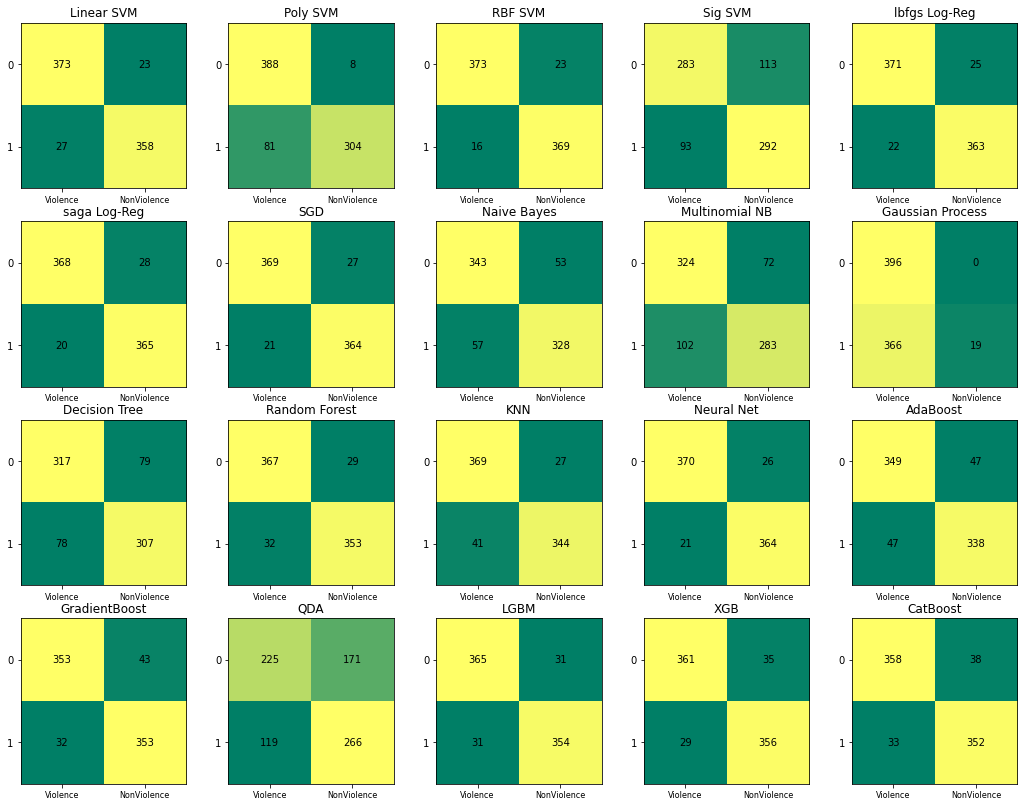

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

for i in range(len(class_names)):
    print("CLASS -",i,"-->",class_names[i])

fig = plt.figure(figsize=(18,14))
fig.tight_layout()
nof_clsfrs = len(names)
Metrics = {}

print('\nClassification Report for each Classifier:')
for i in range(nof_clsfrs):
    metric = []
    classifier = classifiers[i]
    plt.subplot(nof_clsfrs/5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    
    print(f'\n\nClassifier: {str(classifier)[0:25]}...')
    start_time = time.time(); classifier.fit(train_features, train_labels); metric.append(time.time() - start_time); 
    start_time = time.time(); test_pred = classifier.predict(test_features); metric.append(time.time() - start_time);
    acc = accuracy_score(test_labels,test_pred) *100; metric.append(acc);
    Metrics[names[i]] = metric
    #print(f'Accuracy  is {acc}%, Report:')
    print(classification_report(test_labels, test_pred))
    
    plt.gca().set_title(names[i])
    CM = confusion_matrix(test_labels, test_pred)
    plt.imshow(CM,interpolation='nearest',cmap='summer')
    for (i, j), z in np.ndenumerate(CM):
        plt.text(j, i, z, ha='center', va='center')
    plt.xticks(np.arange(len(class_names)),class_names, fontsize=8)
    plt.yticks(np.arange(len(class_names)))
    plt.grid(False)
plt.show()

In [22]:
result = pd.DataFrame(Metrics.values(), columns =['Training-time', 'Prediction-time', 'Accuracy'])
result.index = Metrics.keys()

print("\nClassifier for which max Accuracy is obtained:")
print(result.loc[result["Accuracy"].idxmax()])

print("\n\nClassifier for which min Training-time is obtained:")
print(result.loc[result["Training-time"].idxmin()])

print("\n\nClassifier for which min Prediction-time is obtained:")
print(result.loc[result["Prediction-time"].idxmin()])

print("\n\nResults of all the Classifiers:")
result.sort_values(by="Accuracy", ascending=False)


Classifier for which max Accuracy is obtained:
Training-time       6.804000
Prediction-time     3.578964
Accuracy           95.006402
Name: RBF SVM, dtype: float64


Classifier for which min Training-time is obtained:
Training-time       0.010002
Prediction-time     0.373966
Accuracy           91.293214
Name: KNN, dtype: float64


Classifier for which min Prediction-time is obtained:
Training-time       2.886986
Prediction-time     0.003000
Accuracy           79.897567
Name: Decision Tree, dtype: float64


Results of all the Classifiers:


,Training-time,Prediction-time,Accuracy
RBF SVM,6.804000,3.578964,95.006402
lbfgs Log-Reg,0.977131,0.010998,93.982074
Neural Net,4.050229,0.007006,93.982074
saga Log-Reg,10.961036,0.004995,93.854033
SGD,0.302960,0.011002,93.854033
Linear SVM,4.291034,1.124994,93.597951
Random Forest,2.843001,0.025003,92.189501
LGBM,19.460999,0.020002,92.061460
XGB,13.953036,0.029000,91.805378
KNN,0.010002,0.373966,91.293214


## I3D Model Feature Extracting + ML Classifiers
The I3D model is used to extract the features for every 1.5 seconds of video while saving the median image of the 1.5 seconds of video as well. I3D model used: https://tfhub.dev/deepmind/i3d-kinetics-600/1. </br>
The tensorflow_hub library provides the class hub.KerasLayer that gets initialized with the URL (or filesystem path) of a SavedModel and then provides the computation from the SavedModel, including its pre-trained weights.

### Features extraction
To extract features from a video you should:</br>

(input_dim=(n, 224, 224, 3)).</br>
https://tfhub.dev/deepmind/i3d-kinetics-400/1 (and also the *-600 version) happen to export only the final layer, so there is no properly supported way to get the other layers. (That said, you can always experiment by inspecting the graph and selecting tensors by name, but this has a real risk to stop working with newer module or library versions.) </br>
Average features extracted from all vectors to form a single vector (dim=600).</br>

Architecture:
![alt text](https://miro.medium.com/max/1400/1*20UNfL2azlY3Cz3M0qtJOw.png "Architecture")


In [9]:
import tensorflow_hub as hub
i3d_layer = hub.KerasLayer("https://tfhub.dev/deepmind/i3d-kinetics-600/1", name='I3D')

feature_model = keras.models.Sequential([
    ## preprocessing - Normalization
    keras.layers.Normalization(input_shape=(output_frames, 224, 224, 3)),
    ## Feature Extractor
    i3d_layer,
    ## batch-normalizing for next classifier to train
    keras.layers.BatchNormalization()
])
feature_model._name="I3D_Feature_Extractor"

# Showing C3D Model Architecture
print(i3d_layer.get_config())
print("\nI3D Model Architecture\n")
i3d_layer.variables

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


{'name': 'I3D', 'trainable': False, 'dtype': 'float32', 'handle': 'https://tfhub.dev/deepmind/i3d-kinetics-600/1', 'signature': 'default', 'output_key': 'default'}

I3D Model Architecture



[<tf.Variable 'RGB/inception_i3d/Conv3d_1a_7x7/conv_3d/w:0' shape=(7, 7, 7, 3, 64) dtype=float32>,
 <tf.Variable 'RGB/inception_i3d/Conv3d_1a_7x7/batch_norm/moving_mean:0' shape=(1, 1, 1, 1, 64) dtype=float32>,
 <tf.Variable 'RGB/inception_i3d/Conv3d_1a_7x7/batch_norm/moving_variance:0' shape=(1, 1, 1, 1, 64) dtype=float32>,
 <tf.Variable 'RGB/inception_i3d/Conv3d_1a_7x7/batch_norm/beta:0' shape=(1, 1, 1, 1, 64) dtype=float32>,
 <tf.Variable 'RGB/inception_i3d/Conv3d_2b_1x1/conv_3d/w:0' shape=(1, 1, 1, 64, 64) dtype=float32>,
 <tf.Variable 'RGB/inception_i3d/Conv3d_2b_1x1/batch_norm/moving_mean:0' shape=(1, 1, 1, 1, 64) dtype=float32>,
 <tf.Variable 'RGB/inception_i3d/Conv3d_2b_1x1/batch_norm/moving_variance:0' shape=(1, 1, 1, 1, 64) dtype=float32>,
 <tf.Variable 'RGB/inception_i3d/Conv3d_2b_1x1/batch_norm/beta:0' shape=(1, 1, 1, 1, 64) dtype=float32>,
 <tf.Variable 'RGB/inception_i3d/Conv3d_2c_3x3/conv_3d/w:0' shape=(3, 3, 3, 64, 192) dtype=float32>,
 <tf.Variable 'RGB/inception_i3d/C

### **Extracting the deep features directly from Videos of our Dataset**
*(i.e., model **without** Fully-Connected-Layers[DNN] for Feature-Extracting))*

In [10]:
import time
tf.keras.backend.clear_session
start_time = time.time(); features = feature_model.predict(videos,batch_size=20); feat_time = time.time() - start_time;
print("Time time taken to extract features from complete Data -->:", feat_time, "(s)")

Time time taken to extract features from complete Data -->: 197.50205636024475 (s)


In [11]:
from sklearn.model_selection import train_test_split
train_features,test_features,train_labels,test_labels = train_test_split(features, labels, test_size=.2, shuffle=True)

In [12]:
print("Training data size:", train_features.shape)
print("Test data size:", test_features.shape)

Training data size: (2774, 600)
Test data size: (694, 600)


### *Searching for the best model*
These above features-data is given as inputs for ML-Classifiers and best out them is found

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

names = ["Linear SVM", "Poly SVM", "RBF SVM", "Sig SVM", "lbfgs Log-Reg", 
         "saga Log-Reg", "SGD", "Naive Bayes","KMeans", "Gaussian Process", 
         "Decision Tree", "Random Forest", "KNN", "Neural Net", "AdaBoost", 
         "GradientBoost", "QDA", "LGBM", "XGB", "CatBoost"]

classifiers = [SVC(kernel='linear',max_iter=5000), SVC(kernel='poly',max_iter=5000), 
               SVC(kernel='rbf',max_iter=5000), SVC(kernel='sigmoid',max_iter=5000),
               LogisticRegression(solver='lbfgs'), LogisticRegression(solver='saga'), SGDClassifier(), 
               GaussianNB(), KMeans(n_clusters=len(class_names)), GaussianProcessClassifier(), 
               DecisionTreeClassifier(max_depth=10), RandomForestClassifier(max_depth=10), KNeighborsClassifier(), 
               MLPClassifier(max_iter=1000,early_stopping=True), AdaBoostClassifier(), 
               GradientBoostingClassifier(), QuadraticDiscriminantAnalysis(),
               LGBMClassifier(), XGBClassifier(), CatBoostClassifier(iterations=100,learning_rate=0.1,silent=True)]

#### *Fitting and Ploting results*

CLASS - 0 --> Violence
CLASS - 1 --> NonViolence

Classification Report for each Classifier:


Classifier: SVC(kernel='linear', max_...
              precision    recall  f1-score   support

           0       0.62      0.52      0.57       359
           1       0.56      0.65      0.60       335

    accuracy                           0.59       694
   macro avg       0.59      0.59      0.58       694
weighted avg       0.59      0.59      0.58       694



Classifier: SVC(kernel='poly', max_it...
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       359
           1       0.69      0.77      0.73       335

    accuracy                           0.72       694
   macro avg       0.72      0.72      0.72       694
weighted avg       0.73      0.72      0.72       694



Classifier: SVC(max_iter=5000)...
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       359
           1       0.7

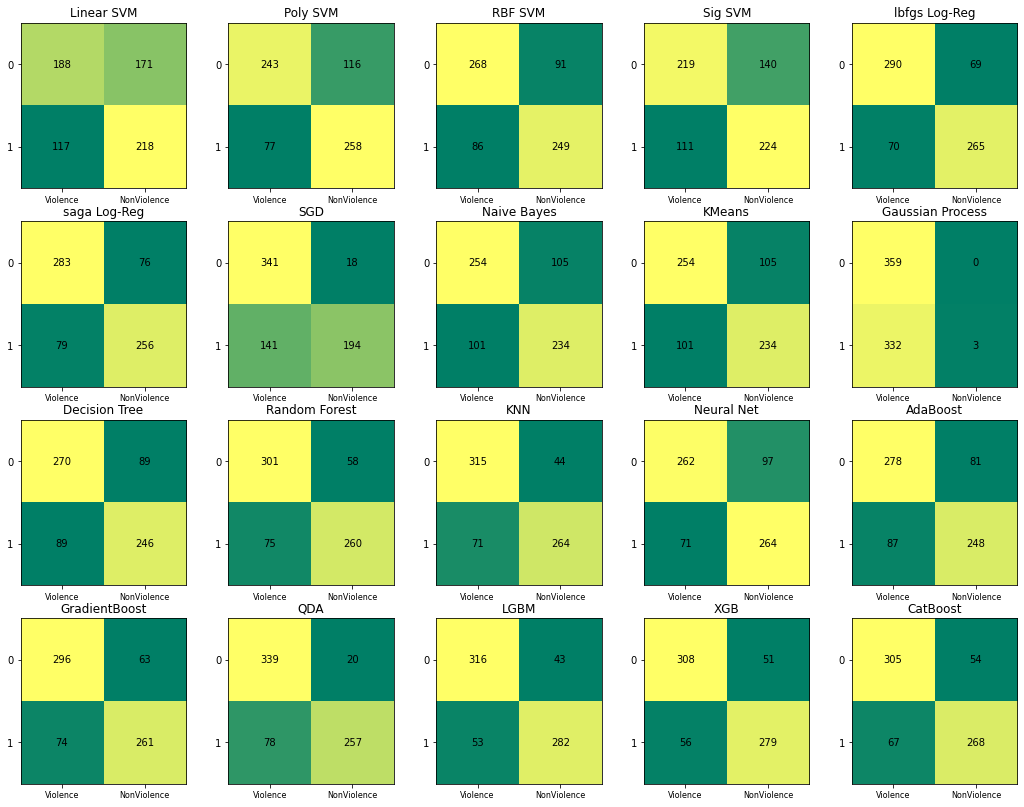

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

for i in range(len(class_names)):
    print("CLASS -",i,"-->",class_names[i])

fig = plt.figure(figsize=(18,14))
fig.tight_layout()
nof_clsfrs = len(names)
Metrics = {}

print('\nClassification Report for each Classifier:')
for i in range(nof_clsfrs):
    metric = []
    classifier = classifiers[i]
    plt.subplot(nof_clsfrs/5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    
    print(f'\n\nClassifier: {str(classifier)[0:25]}...')
    if 'KMeans' in str(classifier):
        # for KMeans, we use the entire features data as it unsupervised
        start_time = time.time(); classifier.fit(features, labels); metric.append(time.time() - start_time);
        metric.append(metric[-1]) # test run time is same
    else:
        start_time = time.time(); classifier.fit(train_features, train_labels); metric.append(time.time() - start_time); 
        start_time = time.time(); test_pred = classifier.predict(test_features); metric.append(time.time() - start_time);
    acc = accuracy_score(test_labels,test_pred) *100; metric.append(acc);
    Metrics[names[i]] = metric
    #print(f'Accuracy  is {acc}%, Report:')
    print(classification_report(test_labels, test_pred))
    
    plt.gca().set_title(names[i])
    CM = confusion_matrix(test_labels, test_pred)
    plt.imshow(CM,interpolation='nearest',cmap='summer')
    for (i, j), z in np.ndenumerate(CM):
        plt.text(j, i, z, ha='center', va='center')
    plt.xticks(np.arange(len(class_names)),class_names, fontsize=8)
    plt.yticks(np.arange(len(class_names)))
    plt.grid(False)
plt.show()

In [15]:
result = pd.DataFrame(Metrics.values(), columns =['Training-time', 'Prediction-time', 'Accuracy'])
result.index = Metrics.keys()

print("\nClassifier for which max Accuracy is obtained:")
print(result.loc[result["Accuracy"].idxmax()])

print("\n\nClassifier for which min Training-time is obtained:")
print(result.loc[result["Training-time"].idxmin()])

print("\n\nClassifier for which min Prediction-time is obtained:")
print(result.loc[result["Prediction-time"].idxmin()])

print("\n\nResults of all the Classifiers:")
result.sort_values(by="Accuracy", ascending=False)


Classifier for which max Accuracy is obtained:
Training-time       2.824891
Prediction-time     0.004997
Accuracy           86.167147
Name: LGBM, dtype: float64


Classifier for which min Training-time is obtained:
Training-time       0.003000
Prediction-time     0.143178
Accuracy           83.429395
Name: KNN, dtype: float64


Classifier for which min Prediction-time is obtained:
Training-time       0.253375
Prediction-time     0.000000
Accuracy           79.971182
Name: lbfgs Log-Reg, dtype: float64


Results of all the Classifiers:


,Training-time,Prediction-time,Accuracy
LGBM,2.824891,0.004997,86.167147
QDA,1.204904,0.011000,85.878963
XGB,7.565497,0.010064,84.582133
KNN,0.003000,0.143178,83.429395
CatBoost,5.826081,0.009999,82.564841
Random Forest,3.615872,0.026138,80.835735
GradientBoost,38.711492,0.005085,80.259366
lbfgs Log-Reg,0.253375,0.000000,79.971182
saga Log-Reg,1.762765,0.000000,77.665706
SGD,0.238011,0.004999,77.089337


---
#### *<div style="text-align: center"> - - - - - Thank You - - - - - <div>*
---